# 3 Combining CNNs and LSTMs

    • Building a neural network with CNNs and LSTMs

    • Building an image caption generator using PyTorch

## Building a neural network with CNNs and LSTMs

This kind of model is deep both spatially – thanks to the CNN component – as well as temporally – thanks to the LSTM network.

The convolutional part of the model is often used as an **encoder** that takes in an input image and outputs high-dimensional features or embeddings.

the LSTM component, which is used as a **decoder** to generate text.

When we are dealing with words we have to make **tokens**, **text encoding**.

### Text encoding demo

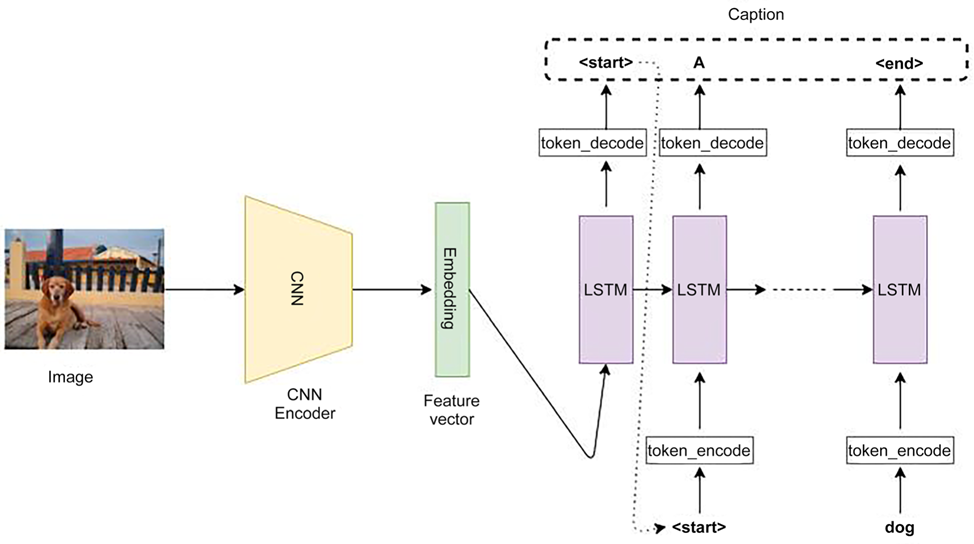

## Building an image caption generator using PyTorch

    we will be using the Common Objects in Context (COCO) dataset

In [ ]:
# !pip install torch==2.2
# !pip install torchvision==0.17
# !pip install nltk==3.7
# !pip install pycocotools==2.0.7

2.5.1+cpu
0.20.1+cpu
3.9.1


### Downloading the image captioning datasets

In [15]:
import os
import wget

urls = [
    "http://images.cocodataset.org/annotations/annotations_trainval2014.zip",
    "http://images.cocodataset.org/zips/train2014.zip",
    "http://images.cocodataset.org/zips/val2014.zip"
]

for url in urls:
    filename = os.path.join('data', url.split('/')[-1])
    print(f"Downloading {url} to {filename}")
    wget.download(url, out=filename)
    print("\n")  # line break after each download

In [18]:
import os
import zipfile
import shutil

In [19]:
# Define paths
data_dir = "./data/"
zipped_files = [
    "annotations_trainval2014.zip",
    "train2014.zip",
    "val2014.zip"
]

# Ensure data directory exists
os.makedirs(data_dir, exist_ok=True)

# Function to extract and delete zip files
def extract_and_remove(zip_path, extract_to):
    if os.path.exists(zip_path):
        print(f"Extracting {zip_path}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Extraction complete: {zip_path}")
        os.remove(zip_path)  # Delete the zip file after extraction
        print(f"Deleted {zip_path}\n")
    else:
        print(f"File not found: {zip_path}\n")

# Process each zip file
for zip_filename in zipped_files:
    zip_path = os.path.join(data_dir, zip_filename)
    extract_and_remove(zip_path, data_dir)

print("All files extracted and cleaned up!")

Extracting ./data/annotations_trainval2014.zip...
Extraction complete: ./data/annotations_trainval2014.zip
Deleted ./data/annotations_trainval2014.zip

Extracting ./data/train2014.zip...
Extraction complete: ./data/train2014.zip
Deleted ./data/train2014.zip

Extracting ./data/val2014.zip...
Extraction complete: ./data/val2014.zip
Deleted ./data/val2014.zip

All files extracted and cleaned up!


### Preprocessing caption (text) data

#### 1. Imports

In [ ]:
import os
import nltk
import pickle
import numpy as np
from PIL import Image
from collections import Counter
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
 
import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import transforms
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pack_padded_sequence

In [ ]:
nltk.download('punkt')

#### 2. Build the vocabulary

In [ ]:
class Vocab(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.w2i = {}
        self.i2w = {}
        self.index = 0
 
    def __call__(self, token):
        if not token in self.w2i:
            return self.w2i['<unk>']
        return self.w2i[token]
 
    def __len__(self):
        return len(self.w2i)
    def add_token(self, token):
        if not token in self.w2i:
            self.w2i[token] = self.index
            self.i2w[self.index] = token
            self.index += 1

def build_vocabulary(json, threshold):
    """Build a simple vocabulary wrapper."""
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)
 
        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))
 
    # If the word frequency is less than 'threshold', then the word is discarded.
    tokens = [token for token, cnt in counter.items() if cnt >= threshold]
 
    # Create a vocab wrapper and add some special tokens.
    vocab = Vocab()
    vocab.add_token('<pad>')
    vocab.add_token('<start>')
    vocab.add_token('<end>')
    vocab.add_token('<unk>')
 
    # Add the words to the vocabulary.
    for i, token in enumerate(tokens):
        vocab.add_token(token)
    return vocab
 
vocab = build_vocabulary(json='data_dir/annotations/captions_train2014.json', threshold=4)
vocab_path = './data_dir/vocabulary.pkl'
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)
print("Total vocabulary size: {}".format(len(vocab)))
print("Saved the vocabulary wrapper to '{}'".format(vocab_path))

### Preprocessing image data

#### 1. the images in the dataset can come in various sizes or shapes,

we need to reshape all the images to a fixed shape so that they can be inputted to the first layer of our CNN model 

    We have to reshaped all the images to 256 x 256 pixels 


In [ ]:
def reshape_image(image, shape):
    """Resize an image to the given shape."""
    return image.resize(shape, Image.LANCZOS)
 
def reshape_images(image_path, output_path, shape):
    """Reshape the images in 'image_path' and save into 'output_path'."""
    if not os.path.exists(output_path):
        os.makedirs(output_path)
 
    images = os.listdir(image_path)
    num_im = len(images)
    for i, im in enumerate(images):
        with open(os.path.join(image_path, im), 'r+b') as f:
            with Image.open(f) as image:
                image = reshape_image(image, shape)
                image.save(os.path.join(output_path, im), image.format)
        if (i+1) % 100 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'."
                   .format(i+1, num_im, output_path))

image_path = './data_dir/train2014/'
output_path = './data_dir/resized_images/'
image_shape = [256, 256]
reshape_images(image_path, output_path, image_shape)

### Defining the image captioning data loader

#### 1. Custom Dataset and Custom Loader


In [ ]:
class CustomCocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, data_path, coco_json_path, vocabulary, transform=None):
        """Set the path for images, captions and vocabulary wrapper.
        
        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = data_path
        self.coco_data = COCO(coco_json_path)
        self.indices = list(self.coco_data.anns.keys())
        self.vocabulary = vocabulary
        self.transform = transform
 
    def __getitem__(self, idx):
        """Returns one data pair (image and caption)."""
        coco_data = self.coco_data
        vocabulary = self.vocabulary
        annotation_id = self.indices[idx]
        caption = coco_data.anns[annotation_id]['caption']
        image_id = coco_data.anns[annotation_id]['image_id']
        image_path = coco_data.loadImgs(image_id)[0]['file_name']
 
        image = Image.open(os.path.join(self.root, image_path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
 
        # Convert caption (string) to word ids.
        word_tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocabulary('<start>'))
        caption.extend([vocabulary(token) for token in word_tokens])
        caption.append(vocabulary('<end>'))
        ground_truth = torch.Tensor(caption)
        return image, ground_truth
 
    def __len__(self):
        return len(self.indices)

#### 2. We define collate_function, which returns mini-batches of data in the form of X, y, as follows:

This link might helps 

In [ ]:
def collate_function(data_batch):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data_batch.sort(key=lambda d: len(d[1]), reverse=True)
    imgs, caps = zip(*data_batch)
 
    # Merge images (from list of 3D tensors to 4D tensor).
    # Originally, imgs is a list of <batch_size> number of RGB images with dimensions (3, 256, 256)
    # This line of code turns it into a single tensor of dimensions (<batch_size>, 3, 256, 256)
    imgs = torch.stack(imgs, 0)
 
    # Merge captions (from list of 1D tensors to 2D tensor), similar to merging of images donw above.
    cap_lens = [len(cap) for cap in caps]
    tgts = torch.zeros(len(caps), max(cap_lens)).long()
    for i, cap in enumerate(caps):
        end = cap_lens[i]
        tgts[i, :end] = cap[:end]        
    return imgs, tgts, cap_lens

#### 3.  implement the get_loader function,
    which returns a custom data loader for the COCO dataset in the following code:

In [ ]:
def get_loader(data_path, coco_json_path, vocabulary, transform, batch_size, shuffle):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    coco_dataser = CustomCocoDataset(data_path=data_path,
                       coco_json_path=coco_json_path,
                       vocabulary=vocabulary,
                       transform=transform)
    
    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    custom_data_loader = torch.utils.data.DataLoader(dataset=coco_dataser, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              collate_fn=collate_function)
    return custom_data_loader

### Defining the CNN-LSTM model

#### 1. Now that we have set up our data pipeline, we will define the model architecture

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, embedding_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(CNNModel, self).__init__()
        resnet = models.resnet152(weights=True)
        module_list = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet_module = nn.Sequential(*module_list)
        self.linear_layer = nn.Linear(resnet.fc.in_features, embedding_size)
        self.batch_norm = nn.BatchNorm1d(embedding_size, momentum=0.01)
        
    def forward(self, input_images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            resnet_features = self.resnet_module(input_images)
        resnet_features = resnet_features.reshape(resnet_features.size(0), -1)
        final_features = self.batch_norm(self.linear_layer(resnet_features))
        return final_features

### 2. the LSTM layer takes in the embedding vectors as input and outputs a sequence of words that should ideally describe the image from which the embedding was generated:

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_size, hidden_layer_size, vocabulary_size, num_layers, max_seq_len=20):
        """Set the hyper-parameters and build the layers."""
        super(LSTMModel, self).__init__()
        self.embedding_layer = nn.Embedding(vocabulary_size, embedding_size)
        self.lstm_layer = nn.LSTM(embedding_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear_layer = nn.Linear(hidden_layer_size, vocabulary_size)
        self.max_seq_len = max_seq_len
        
    def forward(self, input_features, capts, lens):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embedding_layer(caps)
        embeddings = torch.cat((input_features.unsqueeze(1), embeddings), 1)
        lstm_input = pack_padded_sequence(embeddings, lens, batch_first=True) 
        hidden_variables, _ = self.lstm_layer(lstm_input)
        model_outputs = self.linear_layer(hidden_variables[0])
        return model_outputs
    
    def sample(self, input_features, lstm_states=None):
        """Generate captions for given image features using greedy search."""
        sampled_indices = []
        lstm_inputs = input_features.unsqueeze(1)
        for i in range(self.max_seq_len):
            hidden_variables, lstm_states = self.lstm_layer(lstm_inputs, lstm_states)          # hiddens: (batch_size, 1, hidden_size)
            model_outputs = self.linear_layer(hidden_variables.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted_outputs = model_outputs.max(1)                        # predicted: (batch_size)
            sampled_indices.append(predicted_outputs)
            lstm_inputs = self.embedding_layer(predicted_outputs)                       # inputs: (batch_size, embed_size)
            lstm_inputs = lstm_inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_indices = torch.stack(sampled_indices, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_indices

### Training the CNN-LSTM model

#### 1. Device 

    We still need to normalize the data. 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### 2. We will use PyTorch’s transform module to normalize the input image pixel values: 

    Furthermore, we augment the available dataset.

In [ ]:
transform = transforms.Compose([
    transforms.RandomCrop(224), 
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])

Using PyTorch’s transform module, we implement two data augmentation techniques here:

i. Random cropping

ii. Horizontal flipping of the images.

#### 3. Next, we load the vocabulary that we built in the Preprocessing caption (text) data section.

We also initialize the data loader using the get_loader() function defined in the Defining the image captioning data loader section:

In [ ]:
# Load vocabulary wrapper
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)

# Build data loader
custom_data_loader = get_loader('data_dir/resized_images', 'data_dir/annotations/captions_train2014.json', vocabulary, 
                         transform, 128,
                         shuffle=True) 

#### 4. Instanciate the model

Furthermore, we also define the loss function cross entropy loss – and the optimization schedule – the Adam optimizer – as follows:

In [ ]:
# Build the models
encoder_model = CNNModel(256).to(device)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1).to(device)
 
    
# Loss and optimizer
loss_criterion = nn.CrossEntropyLoss()
parameters = list(decoder_model.parameters()) + list(encoder_model.linear_layer.parameters()) + list(encoder_model.batch_norm.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001)

#### 5. run the training loop

In [ ]:
# Train the models
total_num_steps = len(custom_data_loader)
for epoch in range(5):
    for i, (imgs, caps, lens) in enumerate(custom_data_loader):
 
        # Set mini-batch dataset
        imgs = imgs.to(device)
        caps = caps.to(device)
        tgts = pack_padded_sequence(caps, lens, batch_first=True)[0]
 
        # Forward, backward and optimize
        feats = encoder_model(imgs)
        outputs = decoder_model(feats, caps, lens)
        loss = loss_criterion(outputs, tgts)
        decoder_model.zero_grad()
        encoder_model.zero_grad()
        loss.backward()
        optimizer.step()
 
        # Print log info
        if i % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, 5, i, total_num_steps, loss.item(), np.exp(loss.item()))) 
 
        # Save the model checkpoints
        if (i+1) % 1000 == 0:
            torch.save(decoder_model.state_dict(), os.path.join(
                'models_dir/', 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
            torch.save(encoder_model.state_dict(), os.path.join(
                'models_dir/', 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))

### Generating image captions using the trained model

#### 1. We have stored a sample image, sample.jpg, to run inference on. 

In [ ]:
image_file_path = 'sample.jpg'
 

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 

def load_image(image_file_path, transform=None):
    img = Image.open(image_file_path).convert('RGB')
    img = img.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        img = transform(img).unsqueeze(0)
    
    return img

# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

#### 2. Next, we load the vocabulary and instantiate the encoder and decoder models:

In [20]:
# Load vocabulary wrapper
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)


# Build models
encoder_model = CNNModel(256).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1)
encoder_model = encoder_model.to(device)
decoder_model = decoder_model.to(device)

# From last check point 

encoder_model.load_state_dict(torch.load('models_dir/encoder-2-3000.ckpt')) 
decoder_model.load_state_dict(torch.load('models_dir/decoder-2-3000.ckpt'))

FileNotFoundError: [Errno 2] No such file or directory: 'data_dir/vocabulary.pkl'

#### 3. Next, we load the image and run model inference

In [ ]:
# Load the trained model parameters
encoder_model.load_state_dict(torch.load('models_dir/encoder-2-3000.ckpt'))
decoder_model.load_state_dict(torch.load('models_dir/decoder-2-3000.ckpt'))


# Prepare an image
img = load_image(image_file_path, transform)
img_tensor = img.to(device)

#### 4. At this stage, the caption predictions are still in the form of numeric tokens. We need to convert the numeric tokens into actual text using the vocabulary in reverse:

In [ ]:
# Generate an caption from the image
feat = encoder_model(img_tensor)
sampled_indices = decoder_model.sample(feat)
sampled_indices = sampled_indices[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)


# Convert word_ids to words
predicted_caption = []
for token_index in sampled_indices:
    word = vocabulary.i2w[token_index]
    predicted_caption.append(word)
    if word == '<end>':
        break
predicted_sentence = ' '.join(predicted_caption)


#### 5. Once we have transformed our output into text, we can visualize both the image as well as the generated caption:

In [ ]:
# Print out the image and the generated caption
print (predicted_sentence)
img = Image.open(image_file_path)
plt.imshow(np.asarray(img))